DELETE ME (This section is used if running spark on windows)

In [1]:
import findspark

findspark.init()

In [2]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("select 'spark' as hello ")

df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



# Anomaly Detection wikipedia

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

### Wikipedia api

In [45]:
topic = "PFM-1"
start = '20210102'
end = '20220131'
wiki_url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/{topic}/daily/{start}/{end}'

df = pd.read_json(wiki_url)
df = pd.concat([df.drop(['items'], axis=1), df['items'].apply(pd.Series)], axis=1)

In [46]:
df

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,PFM-1,daily,2021010200,desktop,user,43
1,en.wikipedia,PFM-1,daily,2021010300,desktop,user,50
2,en.wikipedia,PFM-1,daily,2021010400,desktop,user,66
3,en.wikipedia,PFM-1,daily,2021010500,desktop,user,49
4,en.wikipedia,PFM-1,daily,2021010600,desktop,user,50
...,...,...,...,...,...,...,...
390,en.wikipedia,PFM-1,daily,2022012700,desktop,user,63
391,en.wikipedia,PFM-1,daily,2022012800,desktop,user,70
392,en.wikipedia,PFM-1,daily,2022012900,desktop,user,30
393,en.wikipedia,PFM-1,daily,2022013000,desktop,user,46


In [530]:
# topic = ""
# start = ""
# end = ""
# wiki_url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/{topic}/daily/{start}/{end}'

# df2 = pd.read_json(wiki_url)

In [534]:
# frames = [df, df2]
# result = pd.concat(frames)

# df = pd.concat([result.drop(['items'], axis=1), result['items'].apply(pd.Series)], axis=1)

In [47]:
df

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,PFM-1,daily,2021010200,desktop,user,43
1,en.wikipedia,PFM-1,daily,2021010300,desktop,user,50
2,en.wikipedia,PFM-1,daily,2021010400,desktop,user,66
3,en.wikipedia,PFM-1,daily,2021010500,desktop,user,49
4,en.wikipedia,PFM-1,daily,2021010600,desktop,user,50
...,...,...,...,...,...,...,...
390,en.wikipedia,PFM-1,daily,2022012700,desktop,user,63
391,en.wikipedia,PFM-1,daily,2022012800,desktop,user,70
392,en.wikipedia,PFM-1,daily,2022012900,desktop,user,30
393,en.wikipedia,PFM-1,daily,2022013000,desktop,user,46


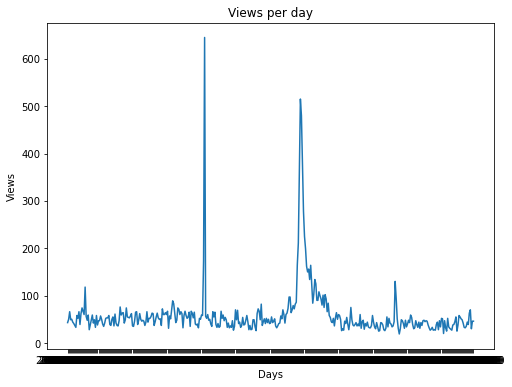

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(df['timestamp'], df['views'])

plt.ylabel('Views')
plt.xlabel('Days')
plt.title('Views per day')
plt.show()

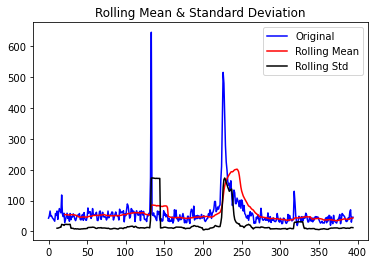

ADF Stastistic: -5.796953
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [49]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
test_stationarity(df['views'])

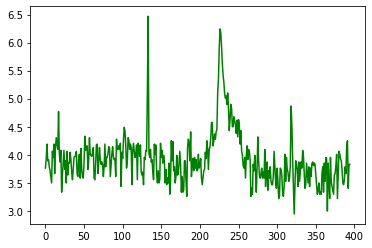

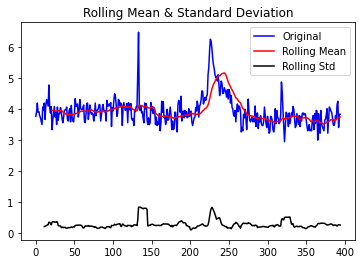

ADF Stastistic: -3.219543
p-value: 0.018881
The graph is non stationery
Critical values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [50]:
import numpy as np

ts_log = np.log(df['views'])
plt.plot(ts_log.values,color="green")
plt.show()

test_stationarity(ts_log)

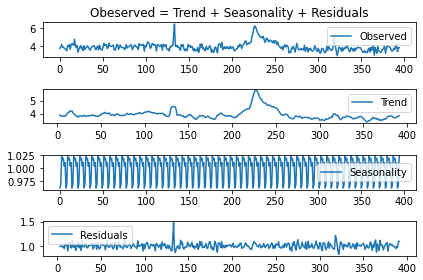

In [51]:
# Naive decomposition of our Time Series as explained above
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, model='multiplicative',period = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.title('Obeserved = Trend + Seasonality + Residuals')
plt.plot(ts_log.values,label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [52]:
ts_log_decompose = residual

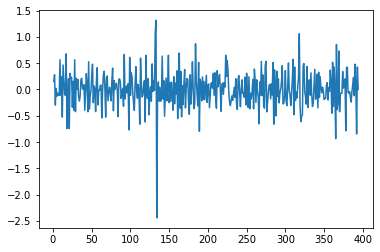

In [53]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.values)
plt.show()

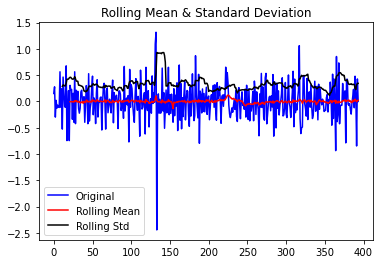

ADF Stastistic: -8.250392
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [54]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


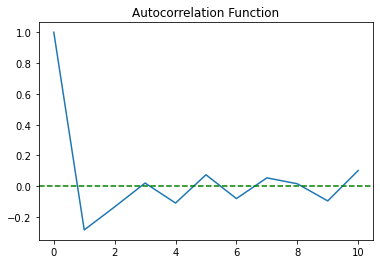

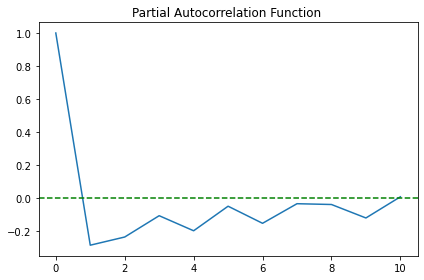

In [55]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(1,1,1)

plt.plot(lag_acf)
#print(lag_acf[0.5])

plt.axhline(y=0,linestyle='--',color='g')
plt.title('Autocorrelation Function')
plt.show()

#Plot PACF:
plt.subplot(1,1,1)
plt.plot(lag_pacf)

plt.axhline(y=0,linestyle='--',color='green')
plt.title('Partial Autocorrelation Function ')
plt.tight_layout()
plt.show()

/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


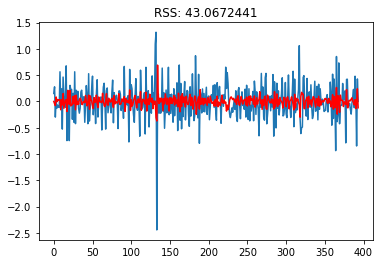

In [56]:
# follow lag
model = ARIMA(ts_log.values, order=(1,1,0))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff.values)**2))
plt.show()

/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


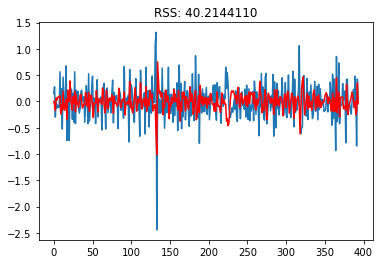

In [57]:
model = ARIMA(ts_log.values, order=(0,1,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff.values)**2))
plt.show()

/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

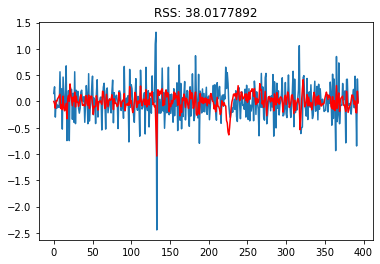

In [58]:
model = ARIMA(ts_log.values, order=(1,1,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff.values)**2))
plt.show()

In [61]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  394
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -98.579
Method:                       css-mle   S.D. of innovations              0.311
Date:                Mon, 21 Mar 2022   AIC                            205.158
Time:                        22:49:48   BIC                            221.064
Sample:                             1   HQIC                           211.461
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.004     -0.049      0.961      -0.009       0.008
ar.L1.D.y      0.3874      0.070      5.499      0.000       0.249       0.525
ma.L1.D.y     -0.8306      0.042    -19.560      0.0

In [63]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [145]:
size = int(len(ts_log)-100)
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = []
originals = []
error_list = []

print('Printing Predicted vs Expected Values...')
print('\n')

index = test_arima.index.start


for t in range(len(test_arima)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    pred_value = output[0]
    print(pred_value)
        
    original_value = test_arima[t + index]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error[0])
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
    #error = mean_squared_error(np.exp(yhat), np.exp(obs))
    #print('mean_squared_error : ', error)
print('\n Means Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')

Printing Predicted vs Expected Values...


[3.80034898]
predicted = 44.716787,   expected = 46.000000,   error = 2.789593  %

 Means Error in Predicting Test Case Articles : 2.789593  %


/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/linuxu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

In [65]:
indexes = []
idx = test_arima.index.start

for index in range(len(predictions)):
    pred_value = predictions[index]
    original_value = originals[index]
    error = ((abs(pred_value - original_value)) / original_value) * 100
    if(error > 15):
        indexes.append(index+idx)
        

timestamp = df['timestamp'].tolist()
    

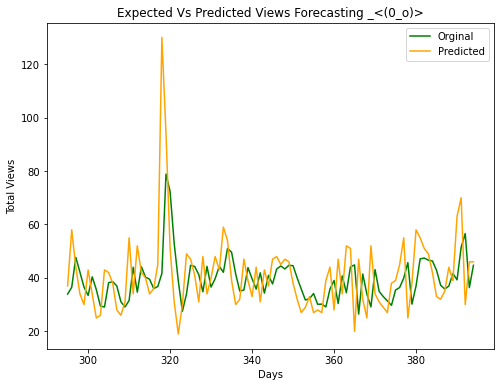

In [66]:
plt.figure(figsize=(8, 6))
index = test_arima.index.start
test_day = [t+index
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting _<(0_o)>')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()

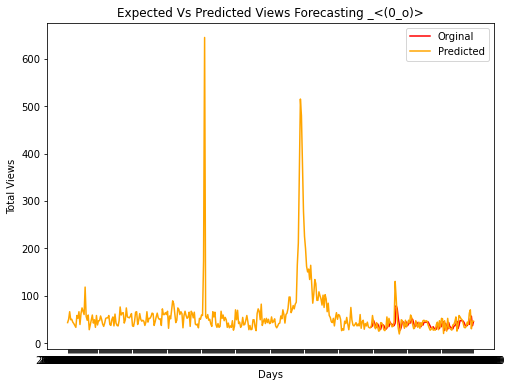

In [67]:
plt.figure(figsize=(8, 6))
index = test_arima.index.start
test_day = [t+index
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'red')
plt.plot(df['timestamp'], df['views'], color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting _<(0_o)>')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()

### Global parameters

In [125]:
predictedAmount = 5
topicToAnomalyThreshouldDic = {}

# Use the preferred method with spark

In [105]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()


sdf = spark.createDataFrame(df)
# sdf = sdf.drop("project","access","agent", "granularity")
sdf.printSchema() #data type of each col
sdf.show(5)
sdf.count()

root
 |-- project: string (nullable = true)
 |-- article: string (nullable = true)
 |-- granularity: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- access: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- views: long (nullable = true)

+------------+-------+-----------+----------+-------+-----+-----+
|     project|article|granularity| timestamp| access|agent|views|
+------------+-------+-----------+----------+-------+-----+-----+
|en.wikipedia|  PFM-1|      daily|2021010200|desktop| user|   43|
|en.wikipedia|  PFM-1|      daily|2021010300|desktop| user|   50|
|en.wikipedia|  PFM-1|      daily|2021010400|desktop| user|   66|
|en.wikipedia|  PFM-1|      daily|2021010500|desktop| user|   49|
|en.wikipedia|  PFM-1|      daily|2021010600|desktop| user|   50|
+------------+-------+-----------+----------+-------+-----+-----+
only showing top 5 rows



395

In [106]:
sdf.createOrReplaceTempView("views")
spark.sql("select article, count(*) from views group by article order by article").show()

+-------+--------+
|article|count(1)|
+-------+--------+
|  PFM-1|     395|
+-------+--------+



In [107]:
sdf = sdf.orderBy("article", "timestamp")
sdf.show(5)

+------------+-------+-----------+----------+-------+-----+-----+
|     project|article|granularity| timestamp| access|agent|views|
+------------+-------+-----------+----------+-------+-----+-----+
|en.wikipedia|  PFM-1|      daily|2021010200|desktop| user|   43|
|en.wikipedia|  PFM-1|      daily|2021010300|desktop| user|   50|
|en.wikipedia|  PFM-1|      daily|2021010400|desktop| user|   66|
|en.wikipedia|  PFM-1|      daily|2021010500|desktop| user|   49|
|en.wikipedia|  PFM-1|      daily|2021010600|desktop| user|   50|
+------------+-------+-----------+----------+-------+-----+-----+
only showing top 5 rows



In [72]:
sdf.explain()

== Physical Plan ==
*(2) Sort [article#1 ASC NULLS FIRST, timestamp#3 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(article#1 ASC NULLS FIRST, timestamp#3 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#88]
   +- *(1) Project [article#1, timestamp#3, views#6L]
      +- *(1) Scan ExistingRDD[project#0,article#1,granularity#2,timestamp#3,access#4,agent#5,views#6L]




Define a data structure for the UDF method:
* 'articale' - the name of the wikipedia topic
* 'error' - the difrence between the original and predicted number in %
* 'prediction' - the predicted number
* 'original' - the original number from wikipedia

In [83]:
from pyspark.sql.types import *

schema = StructType([
                  StructField('article', StringType()),
                  StructField('error', DoubleType()),
                  StructField('prediction', DoubleType()),
                  StructField('original', DoubleType()),
])

- Install 'PyArrow' packag
- Define a UDF to apply to each group in the spark df, we split the df according to the articles to maintain the timeline of the time series. The method creates an Arima model and predicts values and returns a new df that corresponds to the defined schema.

In [135]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def forecast_store_item(history_pd):
    global predictedAmount
    predictions = []
    originals = []
    errors = []

    name = history_pd['article'].iloc[0]
    history_pd = np.log(history_pd['views'])
    size = int(len(history_pd) - predictedAmount)
    train_arima, test_arima = history_pd[0:size], history_pd[size:len(ts_log)]
    history = [x for x in train_arima]
    index = test_arima.index.start
    
    for t in range(len(test_arima)):
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()

        pred_value = output[0]

        original_value = test_arima[t + index]
        history.append(original_value)

        pred_value = np.exp(pred_value)


        original_value = np.exp(original_value)


        error = ((abs(pred_value - original_value)) / original_value) * 100
        errors.append(error[0])

        predictions.append(float(pred_value))
        originals.append(float(original_value))
        
    articls = [name] * len(errors)

    return pd.DataFrame(
        {
            'article': articls,
            'error': errors,
            'prediction': predictions,
            'original': originals
        })

Applay the UDF to each group and create new DF.

In [138]:
from pyspark.sql.functions import current_date
from pyspark.sql.functions import pandas_udf
# sdf.orderBy("article", "timestamp").apply(forecast_store_item)
def applay_udf(sdf):
    sdf_clean = sdf.drop("project","access","agent", "granularity")
    sdf_clean = sdf_clean.orderBy("article", "timestamp")
    res = sdf_clean.groupBy('article').apply(forecast_store_item)
    res.show()

In [139]:
applay_udf(sdf)

+-------+------------------+------------------+--------+
|article|             error|        prediction|original|
+-------+------------------+------------------+--------+
|  PFM-1| 9.797004140007335|41.493378095596626|    46.0|
|  PFM-1|2.8442304583188123|44.691653989173346|    46.0|
+-------+------------------+------------------+--------+



### Display the results

In [547]:
resPandas = res.toPandas()

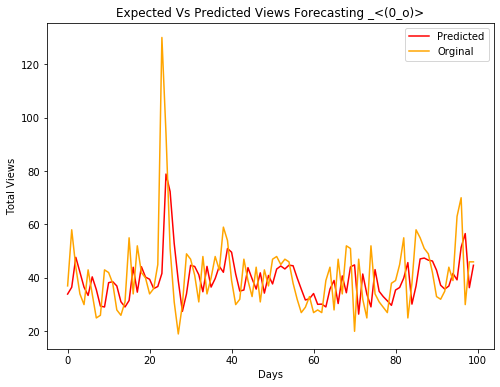

In [527]:
plt.figure(figsize=(8, 6))
test_day = range(0, len(resPandas['prediction']))
labels={'Orginal','Predicted'}
plt.plot(test_day, resPandas['prediction'], color= 'red')
plt.plot(test_day, resPandas['original'], color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()

In [292]:
df3 = spark.createDataFrame([('a', 1, 0), ('a', -1, 42), ('b', 3, -1),
                            ('b', 10, -2)], ('key', 'value1', 'value2'))

from pyspark.sql.types import *

schema = StructType([StructField('key', StringType()),
                    StructField('avg_value1', DoubleType()),
                    StructField('avg_value2', DoubleType()),
                    StructField('sum_avg', DoubleType()),
                    StructField('sub_avg', DoubleType())])


@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def g(df):
    gr = df['key'].iloc[0]
    x = df.value1.mean()
    y = df.value2.mean()
    w = df.value1.mean() + df.value2.mean()
    z = df.value1.mean() - df.value2.mean()
    return pd.DataFrame([[gr] + [x] + [y] + [w] + [z]])

df3.groupby('key').apply(g).show()

+---+----------+----------+-------+-------+
|key|avg_value1|avg_value2|sum_avg|sub_avg|
+---+----------+----------+-------+-------+
|  a|       0.0|      21.0|   21.0|  -21.0|
|  b|       6.5|      -1.5|    5.0|    8.0|
+---+----------+----------+-------+-------+



## Get data with kafka

In [121]:
from confluent_kafka import Consumer

conf = {'bootstrap.servers': "localhost:9092",
        'group.id': "foo",
        'auto.offset.reset': 'smallest'}

consumer = Consumer(conf)

In [122]:
import pandas as pd

running = True

def basic_consume_loop(consumer, topics):
    global sdf
    try:
        consumer.subscribe(topics)

        while running:
            msg = consumer.poll(timeout=3.0)
            if msg is None: continue

            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    # End of partition event
                    sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                     (msg.topic(), msg.partition(), msg.offset()))
                elif msg.error():
                    raise KafkaException(msg.error())
            else:
                print(msg.topic(), msg.partition(), msg.offset(), msg.key(), msg.value().decode('utf-8'))
                print('==========')
                data = msg.value().decode('utf-8')
                try:
                    new_df= pd.read_json(data)
                    new_df = pd.concat([new_df.drop(['items'], axis=1), new_df['items'].apply(pd.Series)], axis=1)
                    display(new_df)
                    snew_df = spark.createDataFrame(new_df)
                    snew_df.show()
                    sdf = sdf.union(snew_df)
                    sdf.show()
                    applay_udf(sdf)
                except:
                    print("Oops!", sys.exc_info()[0], "occurred.")
    finally:
        # Close down consumer to commit final offsets.
        consumer.close()

def shutdown():
    running = False

In [123]:
basic_consume_loop(consumer, ['wiki'])

wiki 0 23 b'myKey' [{"items":{"project":"en.wikipedia","article":"PFM-1","granularity":"daily","timestamp":"2022032000","access":"desktop","agent":"user","views":205}}]


,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,PFM-1,daily,2022032000,desktop,user,205


+------------+-------+-----------+----------+-------+-----+-----+
|     project|article|granularity| timestamp| access|agent|views|
+------------+-------+-----------+----------+-------+-----+-----+
|en.wikipedia|  PFM-1|      daily|2022032000|desktop| user|  205|
+------------+-------+-----------+----------+-------+-----+-----+

+------------+-------+-----------+----------+-------+-----+-----+
|     project|article|granularity| timestamp| access|agent|views|
+------------+-------+-----------+----------+-------+-----+-----+
|en.wikipedia|  PFM-1|      daily|2021010200|desktop| user|   43|
|en.wikipedia|  PFM-1|      daily|2021010300|desktop| user|   50|
|en.wikipedia|  PFM-1|      daily|2021010400|desktop| user|   66|
|en.wikipedia|  PFM-1|      daily|2021010500|desktop| user|   49|
|en.wikipedia|  PFM-1|      daily|2021010600|desktop| user|   50|
|en.wikipedia|  PFM-1|      daily|2021010700|desktop| user|   44|
|en.wikipedia|  PFM-1|      daily|2021010800|desktop| user|   41|
|en.wikip

/usr/local/spark/spark/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------+-----+----------+--------+
|article|error|prediction|original|
+-------+-----+----------+--------+
+-------+-----+----------+--------+



KeyboardInterrupt: 